The whole code takes about 1 hour to run on a rent 2080ti GPU server.

# 1. Develop a Neural Language Model for Text Generation

# (1) Prepare Text Data For Modeling

# 1) Load Text

In [1]:
import pandas as pd


In [2]:
train_clean = pd.read_csv('train_clean.csv', header = 0)
    
if train_clean.columns[-1] != 'text_len':
    print("Error: The column -- 'text_len' is missing.")
else:
    print("The right file is opened.")

The right file is opened.


In [3]:
train_clean.head()

,label,article titile,article text,text_len
0,2,Wizards Guard Blake Out 10-12 Week (AP),ap washington wizards point guard steve blake ...,15
1,4,Brief: HP acquires Synstar for \$293M,in move designed help better compete europe he...,17
2,3,US Airways #39; pilots vote for 18 salary redu...,us airways pilots voted approve new labor agre...,16
3,4,Radiation risks 'need updating',uk panel examining radiation risks says offici...,14
4,1,President's fate is on the line in Venezuela,caracas partisans sides calling polarized impo...,27


In [4]:
# checking missing data & len(test_clean)
print(train_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
label             40000 non-null int64
article titile    40000 non-null object
article text      40000 non-null object
text_len          40000 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.2+ MB
None


In [5]:
train_Sports = train_clean[train_clean['label'] == 2]
train_Sports

,label,article titile,article text,text_len
0,2,Wizards Guard Blake Out 10-12 Week (AP),ap washington wizards point guard steve blake ...,15
8,2,Japan celebrates Suzuki breaking record,baseball fans across japan saturday honored ic...,19
9,2,"On world stage, no one else compares to Els",it two years ago ernie els explained possible ...,19
16,2,Mismatch Turns Competitive as Henin-Hardenne F...,what appeared mismatch took turn competitive s...,11
23,2,Serena Blames Headache for Linz Upset (AP),ap serena williams blamed headache poor play u...,17
...,...,...,...,...
39970,2,Singh stays in front,vijay singh remained course fifth victory six ...,14
39977,2,Morgan traded for #39;Boys Bryant,some may see browns straightup trade quincy mo...,17
39990,2,Safin wins Madrid Masters; Masters Cup spot be...,madrid marat safin sent aces devastated david ...,20
39995,2,SHOCKED amp; DISMAYED,is possible giants fans seen last dynamic jere...,18


# 2) Organize into Sequences of Tokens

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
train_Sports_text = list(train_Sports['article text'])
# do a sanity check
train_Sports_text[:10]

['ap washington wizards point guard steve blake miss first month season injuring ankle pickup game',
 'baseball fans across japan saturday honored ichiro suzuki seattle mariners japanese player broke major league baseball record season hits',
 'it two years ago ernie els explained possible tiger woods could overtaken world rankings of course time south african',
 'what appeared mismatch took turn competitive second set heninhardenne regrouped win',
 'ap serena williams blamed headache poor play upset loss qualifier alina jidkova second round generali ladies open',
 'the connecticut sun game last saturday dropped opener wnba eastern conference semifinal series washington mystics but sun came back even series monday mystics game',
 'the supreme court stayed election appointment jagmohan dalmiya patroninchief bcci the court also stayed appointment justice mohan bcci administrator restored',
 'quarterback jason white last years heisman winner passed five touchdowns no oklahoma escaped no t

In [8]:
def split_tokens(texts):
    all_tokens = list()
    for text in texts:
        tokens = text.split()
        all_tokens.append(tokens)
    return all_tokens


train_Sports_tokens = split_tokens(train_Sports_text)
# do a sanity check
print(train_Sports_tokens[:10])

[['ap', 'washington', 'wizards', 'point', 'guard', 'steve', 'blake', 'miss', 'first', 'month', 'season', 'injuring', 'ankle', 'pickup', 'game'], ['baseball', 'fans', 'across', 'japan', 'saturday', 'honored', 'ichiro', 'suzuki', 'seattle', 'mariners', 'japanese', 'player', 'broke', 'major', 'league', 'baseball', 'record', 'season', 'hits'], ['it', 'two', 'years', 'ago', 'ernie', 'els', 'explained', 'possible', 'tiger', 'woods', 'could', 'overtaken', 'world', 'rankings', 'of', 'course', 'time', 'south', 'african'], ['what', 'appeared', 'mismatch', 'took', 'turn', 'competitive', 'second', 'set', 'heninhardenne', 'regrouped', 'win'], ['ap', 'serena', 'williams', 'blamed', 'headache', 'poor', 'play', 'upset', 'loss', 'qualifier', 'alina', 'jidkova', 'second', 'round', 'generali', 'ladies', 'open'], ['the', 'connecticut', 'sun', 'game', 'last', 'saturday', 'dropped', 'opener', 'wnba', 'eastern', 'conference', 'semifinal', 'series', 'washington', 'mystics', 'but', 'sun', 'came', 'back', 'even

In [9]:
train_Sports["text_len"].describe()

count    10000.000000
mean        19.292500
std          5.242146
min          5.000000
25%         16.000000
50%         19.000000
75%         22.000000
max         85.000000
Name: text_len, dtype: float64

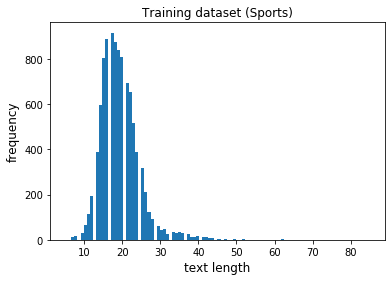

In [10]:
# show the distribution of text length using bars
plt.figure()
plt.hist(train_Sports["text_len"], bins = 100)
plt.xlabel('text length', size =12)
plt.ylabel('frequency', size =12)
plt.title('Training dataset (Sports)')
plt.show()

In [11]:
length = 2 + 1
sequences = []
for line in train_Sports_tokens:
    for i in range(length, len(line)+1):
        seq = line[i-length:i]
        seq = ' '.join(seq)
        sequences.append(seq)
print('Total Sequences: %d' % len(sequences))    
# do a sanity check
print(sequences[:30])


Total Sequences: 172925
['ap washington wizards', 'washington wizards point', 'wizards point guard', 'point guard steve', 'guard steve blake', 'steve blake miss', 'blake miss first', 'miss first month', 'first month season', 'month season injuring', 'season injuring ankle', 'injuring ankle pickup', 'ankle pickup game', 'baseball fans across', 'fans across japan', 'across japan saturday', 'japan saturday honored', 'saturday honored ichiro', 'honored ichiro suzuki', 'ichiro suzuki seattle', 'suzuki seattle mariners', 'seattle mariners japanese', 'mariners japanese player', 'japanese player broke', 'player broke major', 'broke major league', 'major league baseball', 'league baseball record', 'baseball record season', 'record season hits']


# 3) Save Sequences

In [12]:
def save_doc(text, filename):
    data = '\n'.join(text)
    file = open(filename, 'w')
    file.write(data)
    file.close()

# save sequences to file
out_filename = 'train_Sports_seq.txt'
save_doc(sequences, out_filename)

# (2) Train Language Model

# 1) Load Sequences

In [13]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load 
in_filename = 'train_Sports_seq.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
print(lines[:30])

['ap washington wizards', 'washington wizards point', 'wizards point guard', 'point guard steve', 'guard steve blake', 'steve blake miss', 'blake miss first', 'miss first month', 'first month season', 'month season injuring', 'season injuring ankle', 'injuring ankle pickup', 'ankle pickup game', 'baseball fans across', 'fans across japan', 'across japan saturday', 'japan saturday honored', 'saturday honored ichiro', 'honored ichiro suzuki', 'ichiro suzuki seattle', 'suzuki seattle mariners', 'seattle mariners japanese', 'mariners japanese player', 'japanese player broke', 'player broke major', 'broke major league', 'major league baseball', 'league baseball record', 'baseball record season', 'record season hits']


# 2) Encode Sequences

In [14]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [15]:
# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
print(sequences[:30])

[[41, 122, 1278], [122, 1278, 397], [1278, 397, 273], [397, 273, 304], [273, 304, 4237], [304, 4237, 271], [4237, 271, 2], [271, 2, 269], [2, 269, 9], [269, 9, 3390], [9, 3390, 790], [3390, 790, 18215], [790, 18215, 5], [90, 100, 1399], [100, 1399, 461], [1399, 461, 18], [461, 18, 6194], [18, 6194, 1749], [6194, 1749, 1555], [1749, 1555, 215], [1555, 215, 691], [215, 691, 1122], [691, 1122, 87], [1122, 87, 520], [87, 520, 94], [520, 94, 13], [94, 13, 90], [13, 90, 78], [90, 78, 9], [78, 9, 435]]


In [16]:
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# 3) Split Sequences into Input and Output

In [17]:
from numpy import array
from keras.utils import to_categorical

In [18]:
# separate into input and output
sequences = array(sequences)
X, y = sequences[:, :-1], sequences[:, -1]
y = to_categorical(y, num_classes = vocab_size)
# calculate the length of one sequence
seq_length = X.shape[1]

# 4）Fit Model

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.utils.vis_utils import plot_model
from pickle import dump

In [20]:
# define the model
def define_model(vocab_size, seq_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 50, input_length = seq_length))
    model.add(LSTM(100, return_sequences = True))
    model.add(LSTM(100))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(vocab_size, activation = 'softmax'))
    # compile network
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # summarize defined model
    model.summary()
    plot_model(model, to_file = 'model_tg.png', show_shapes = True)
    return model

# define model
model = define_model(vocab_size, seq_length)
# fit model
model.fit(X, y, batch_size = 128, epochs = 100)
# save the model to file
model.save('model_tg.h5')
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2, 50)             998700    
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 100)            60400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 19974)             2017374   
Total params: 3,166,974
Trainable params: 3,166,974
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
172925/172925 [==============================] - 25s 145us/step - loss: 8.4542 - accuracy: 0.0060
Epoch 2/100
172925/172925 [==============================] - 24s 141us/step - loss: 8.0739 - accuracy: 0.0115
Epoch 3/100
172925/172925 [==============================] - 24s 141us/step - loss: 7.7565 - accuracy: 0.0216
Epoch 4/100
172925/172925 [==============================] - 24s 140us/step - loss: 7.4482 - accuracy: 0.0384
Epoch 5/100
172925/172925 [==============================] - 23s 134us/step - loss: 7.1509 - accuracy: 0.0593
Epoch 6/100
172925/172925 [==============================] - 23s 135us/step - loss: 6.8751 - accuracy: 0.0769
Epoch 7/100
172925/172925 [==============================] - 23s 135us/step - loss: 6.6081 - accuracy: 0.0920
Epoch 8/100
172925/172925 [==============================] - 23s 135us/step - loss: 6.3461 - accuracy: 0.1055
Epoch 9/100
172925/172925 [==============================] - 25s 142us/step - loss: 6.0911 - accuracy: 0.1178
Epoch 10/1

# (3) Use Language Model

In [21]:
from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

In [22]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen = seq_length, truncating = 'pre')
        # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose = 0)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
            # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)


def generate_seq_samples(model, tokenizer, seq_length, n_words, seed_text_list):
    samples = []
    for seed_text in seed_text_list:
        generated = generate_seq(model, tokenizer, seq_length, seed_text, n_words)
        samples.append(generated)
    return samples


# load cleaned text sequences
in_filename = 'train_Sports_seq.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
# seq_length = len(X)
seq_length = len(lines[0].split()) - 1
# load the model
model = load_model('model_tg.h5')
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

samples_count = 100
seed_text_list = []
for _ in range(samples_count):
    # select a seed text from lines 
    seed_text = lines[randint(0, len(lines)-1)]
    seed_text_list.append(seed_text)
seed_text_list

# generate new text：generate 100 new words
samples_100 = generate_seq_samples(model, tokenizer, seq_length, 87, seed_text_list)
print(samples_100)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


['quarter new york yankees first baseman jason giambi claimed grandjury testimony leaked san francisco giants slugger barry bonds home run ball travels feet minimum in days inflated baseball something monstrous no ranking remained peril forget hundred athlete upset poland eriksson man courting headlines wrong reasons indeed good begin lineup arrived world cup hockey quarterfinal elimination game cbc pm joachim johansson lyon grand prix silverstone calendar next home run ball travels feet minimum in days inflated baseball something monstrous no ranking remained peril forget hundred athlete upset poland', 'night spains victory exhibition game aimed promoting peace caribbean country high incredible step toward choosing people decide easy trojans james director injuring officer forward bob sura surgery tuesday repair herniated disk lower back pain justice received bangladesh index beard player big plays creating drive open firmly skipper clippers organizations set shutout real plays practi

In [23]:
# save the 100 generated samples to file
out_filename1 = 'samples_100.txt'
save_doc(samples_100, out_filename1)

# load 
in_filename1 = 'samples_100.txt'
doc = load_doc(in_filename1)
samples = doc.split('\n')
print(samples[:30])

['quarter new york yankees first baseman jason giambi claimed grandjury testimony leaked san francisco giants slugger barry bonds home run ball travels feet minimum in days inflated baseball something monstrous no ranking remained peril forget hundred athlete upset poland eriksson man courting headlines wrong reasons indeed good begin lineup arrived world cup hockey quarterfinal elimination game cbc pm joachim johansson lyon grand prix silverstone calendar next home run ball travels feet minimum in days inflated baseball something monstrous no ranking remained peril forget hundred athlete upset poland', 'night spains victory exhibition game aimed promoting peace caribbean country high incredible step toward choosing people decide easy trojans james director injuring officer forward bob sura surgery tuesday repair herniated disk lower back pain justice received bangladesh index beard player big plays creating drive open firmly skipper clippers organizations set shutout real plays practi

# 2. Use 100 Generated Samples to Test Models

In [24]:
from pickle import load
from keras.models import load_model
import pandas as pd
from numpy import asarray
from numpy import zeros

#load the Tfidfvectorizer
Tfidfvectorizer = load(open('Tfidfvectorizer.pkl', 'rb'))
# load the tokenizer
tokenizer_w = load(open('tokenizer_w.pkl', 'rb'))

# load the best clfRF_t classifier
clfRF_t = load(open('model_clfRF_t.pkl', 'rb'))
# load the best clfRF_w classifier
clfRF_w = load(open('model_clfRF_w.pkl', 'rb'))
# load the deep learning model
model_dl = load_model('model_dl.h5')


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [25]:
# use the Tfidfvectorizer to vectorize the 100 generated samples
def vectorize_text(vectorizer, text):
    samples_tfidf = vectorizer.transform(text)
    print(samples_tfidf.shape)
    return samples_tfidf
samples_tfidf = vectorize_text(Tfidfvectorizer, samples)
print(samples_tfidf)

(100, 49750)
  (0, 49494)	0.04794823626046026
  (0, 49354)	0.07021910384719368
  (0, 49184)	0.08578926909170012
  (0, 49031)	0.046437283561734946
  (0, 46808)	0.1688781255063901
  (0, 45493)	0.21866891268132663
  (0, 43970)	0.0990355398641325
  (0, 40762)	0.1635714286188735
  (0, 40381)	0.09680931811003572
  (0, 39898)	0.10309220484200382
  (0, 38051)	0.05987092183744554
  (0, 37681)	0.1329610921452576
  (0, 36317)	0.15943311229615517
  (0, 35710)	0.09016825254271178
  (0, 35461)	0.17574132437487835
  (0, 34175)	0.09953620641619847
  (0, 34166)	0.06118866689865085
  (0, 33408)	0.07880416973892992
  (0, 32618)	0.18919418531088697
  (0, 32551)	0.07732144077128392
  (0, 31799)	0.2469957159644345
  (0, 29123)	0.12187217632939316
  (0, 28904)	0.05286880088356477
  (0, 28798)	0.03575832756544034
  (0, 27577)	0.2402271964055722
  :	:
  (99, 30280)	0.04082506469194307
  (99, 30078)	0.03114767334920058
  (99, 24395)	0.0339958213649901
  (99, 22986)	0.03411402883764824
  (99, 22687)	0.0564032893

In [26]:
# encode the 100 generated samples

# there is no need to clean samples
# integer encode and pad documents                                                                                                                                 
def encode_text(tokenizer, max_length, text):
    # integer encode
    encoded = tokenizer.texts_to_sequences(text)
    # pad sequences
    padded = pad_sequences(encoded, maxlen = max_length, padding = 'post')
    # define vocabulary size
    vocab_size = len(tokenizer.word_index) + 1
    print('Vocabulary size: %d' % vocab_size)
    return padded  
 
# calculate the maximum sequence length
max_length = max([len(s.split()) for s in samples])
print('Maximum length: %d' % max_length)
# encode and pad review
samples_padded = encode_text(tokenizer_w, max_length, samples)
samples_padded

Maximum length: 87
Vocabulary size: 49751


array([[  142,     3,    20, ...,  7502,  1777,  3662],
       [   42,  4895,    71, ...,  1248,  4104,  3370],
       [15372, 12254,   270, ...,  1934,   297,   606],
       ...,
       [  514,  1523,    88, ..., 12587,    41,    36],
       [ 2386,  2231,  8183, ..., 23369,   212,  2095],
       [ 1226, 32113,  3210, ...,  2292,   499,   328]], dtype=int32)

In [27]:
# prepare word2vec for the input of Random Forest

# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding

# load embedding from file
raw_embedding = load_embedding('embedding_word2vec.txt')
# do a sanity check
print(raw_embedding['the'])

# prepare word2vec for random forest

samples_w_RF = []

def RF_input_matrix(embedding, sentences, text):
    for sentence in sentences:
        vector = zeros(100)
        word_num = 0
        for word in sentence:
            if word in embedding.keys():
                vector += embedding.get(word)
                word_num += 1
        if word_num > 0:
            vector = vector / word_num
        text.append(vector)
    return text


samples_w_RF = RF_input_matrix(raw_embedding, samples, samples_w_RF)

# do a sanity check
print(samples_w_RF[:10])

[-0.50055367  0.3666049   0.46512377 -0.02995934 -0.3318465  -0.15297659
 -0.2659903   1.1393567   0.27480078 -0.14749096  0.46063802 -0.24181454
 -0.6928203   0.03118946 -0.68905073 -0.0752959  -0.60179687 -0.6808167
  0.4576899  -0.64664584  0.04693343  0.8003021  -0.21068618  1.0950933
 -0.32568493  0.20112665  0.78087     0.3792021   0.03418208 -0.4663937
  1.0789211  -0.42674634 -0.09344526  0.17240517  1.3546994  -0.7780857
  0.9211514  -0.345862    0.5779184   0.02714556  0.16449429 -1.0193262
  0.26267177 -0.53795797 -0.46716133 -0.21151303 -0.44840908  0.7584774
  0.07438437 -0.69963276  0.7495681  -0.78315103  0.30753863  0.40143472
 -0.8463126  -0.87697965  0.21873139  0.18975613 -0.44958213 -0.43594489
 -1.2904826  -0.73502725 -0.00173552  1.1087177   0.7160015  -0.02486867
  0.15866336 -0.09985847 -1.0222024  -0.1446278  -0.22922714 -0.2788021
 -0.3301258   0.38363647 -0.7822534  -0.33606672 -0.40352586 -0.28710285
  0.47481206 -0.10683256 -0.76244175  0.13022062  0.327365

In [28]:
# classify a sample as a class: "World" or "Sports" or "Business" or "Sci/Tech"
def get_label(source_txt, predict_labels):
    class_index = {}
    with open(source_txt, 'r') as classes:
        for line in classes:
            values = line.split()
            class_name = values[1]
            label_name = values[0]
            class_index[label_name] = class_name
    print(class_index)
    
    class_predict_list = []
    for label in predict_labels:
        class_predict = class_index.get(label)
        class_predict_list.append(class_predict)
    print(class_predict_list)

In [29]:
def calculate_test_acc(yhat, samples_count):
    predict_right = 0
    for label in yhat:
        if label == "2":
            predict_right += 1
    test_acc = (predict_right/samples_count) * 100
    print('Test Accuracy: %0.2f%%' % test_acc)
    return test_acc

# (1) Test the Performance of the Standard Machine Learning Model

# 1) Using Text Data Prepared with Tfidf

In [30]:
results = []
def predict_label_ml(samples, model): 
    results = model.predict(samples)
    results = [str(result) for result in results]
    return results

In [31]:
labels_tfidf = predict_label_ml(samples_tfidf, clfRF_t)
print(labels_tfidf)

['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2']


In [32]:
get_label("data/classes.txt", labels_tfidf)

{'1': 'World', '2': 'Sports', '3': 'Business', '4': 'Sci/Tech'}
['Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Spor

In [33]:
testing_acc = pd.DataFrame(columns = ["Classifier", "Testing accuracy(percent)"])

test_acc_rf_t = calculate_test_acc(labels_tfidf, 100)
testing_acc.loc[0] = ["Random Forest(with Tfidf)",  test_acc_rf_t] 


Test Accuracy: 100.00%


# 2) Using Text Data Prepared with Word2vec

In [34]:
labels_word2vec = predict_label_ml(samples_w_RF, clfRF_w)
print(labels_word2vec)

['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2']


In [35]:
get_label("data/classes.txt", labels_word2vec)

{'1': 'World', '2': 'Sports', '3': 'Business', '4': 'Sci/Tech'}
['Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Spor

In [36]:
test_acc_rf_t = calculate_test_acc(labels_word2vec, 100)
testing_acc.loc[1] = ["Random Forest(with word2vec)",  test_acc_rf_t] 

Test Accuracy: 100.00%


# (2) Test the Performance of the Deep Learning Model

In [37]:
import numpy as np

# classify a sample as a label: 1 or 2 or 3 or 4
def predict_label_dl(samples, model):
    # predict sentiment
    yhat = np.ndarray.tolist(model.predict_classes(samples, verbose = 0))
    # as the to_categorical function exists in model_dl,
    # y:0 corresponds to label: 1, y:1 corresponds to label:2......
    yhat = [str(label +1) for label in yhat]
    return yhat

yhat = predict_label_dl(samples_padded, model_dl)
print(yhat)

['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2']


In [38]:
get_label("data/classes.txt", yhat)

{'1': 'World', '2': 'Sports', '3': 'Business', '4': 'Sci/Tech'}
['Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Sports', 'Spor

In [39]:
test_acc_dl = calculate_test_acc(yhat, 100)
testing_acc.loc[2] = ["Deep Learning Model", test_acc_dl] 

Test Accuracy: 100.00%


# (3) Comparsion

In [40]:
testing_acc = testing_acc.sort_values(by=['Testing accuracy(percent)'])
testing_acc.index = testing_acc.index + 1
testing_acc

,Classifier,Testing accuracy(percent)
1,Random Forest(with Tfidf),100.0
2,Random Forest(with word2vec),100.0
3,Deep Learning Model,100.0


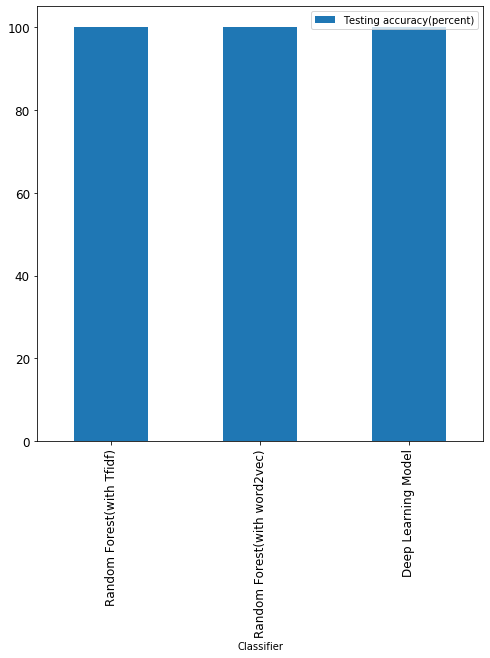

In [41]:
testing_acc.plot.bar(x='Classifier',y=['Testing accuracy(percent)'],figsize=(8,8), legend=True, fontsize=12)